## Graph Neural Networks



In [1]:
!pip -q install torch_geometric

import torch
import numpy as np
import scipy.sparse as sp


## Data Selection and Graph Analysis (Tasks 1 and 2)

In [2]:
#### TODO: Task 1 - Data Selection

import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import kagglehub
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler

## (1) Load RSSI dataset from Kaggle
path = kagglehub.dataset_download("amirma/indoor-location-determination-with-rssi")
csv_path = os.path.join(path, "rssi.csv")
df = pd.read_csv(csv_path)

## (2) Preprocessing
df['signal'] = -df['signal'] # Note: RSSI values in the table are negated.
df = df.dropna(subset=['sequence']) # Drop rows with missing values

# Pivoting with positions & fill NaN with -100 dBm
pivot = df.pivot_table(index=['x', 'y', 'z', 'sequence'], columns='ap', values='signal').fillna(-100)

# Group measurements by position and flatten each set of sequences
grouped = pivot.groupby(['x', 'y', 'z'])
features_list = []
positions_list = []

for (x, y, z), group in grouped:
    max_seq = 100  # max. number of sequences per position
    # Randomly sample up to `max_seq` sequences per location
    if len(group) >= max_seq:
        group = group.sample(n=max_seq, random_state=42)
    # Pad if not enough samples
    while len(group) < max_seq:
        group = pd.concat([group, pd.DataFrame([[-100]*group.shape[1]], columns=group.columns)], ignore_index=True)

    # Flatten RSSI: (max_seq × num_AP) → 1D vector
    feature = group.to_numpy().flatten()
    features_list.append(feature)
    positions_list.append([x, y]) # Extract only X,Y since Z coordinate is either 1 or 2
                                                      # Predicting Z coordinate in indoor condition is meaningless

# Scaling to remove outliers (padded RSSI values: -100)
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features_list)

# Convert to torch tensors
rssi = torch.tensor(features_scaled, dtype=torch.float)
pos = torch.tensor(positions_list, dtype=torch.float)

# (3) Edge connection with K-NN
K = 10  # connect to physical neighbors
coords = pos.numpy()

nbrs = NearestNeighbors(n_neighbors=K + 1).fit(coords)
distances, indices = nbrs.kneighbors(coords)

edges = []
for i in range(len(coords)):
    for j in indices[i][1:]:
        edges.append((i, j))
        edges.append((j, i))

edge_index = torch.tensor(edges, dtype=torch.long).T

# (4) Create graph data object
data = Data(rssi=rssi, edge_index=edge_index, pos=pos)
print(data)

C:\Users\WMNL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(edge_index=[2, 5800], pos=[290, 2], rssi=[290, 400])


In [3]:
# Train/Test split
from sklearn.model_selection import train_test_split

idx = np.arange(data.num_nodes)
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.test_mask[test_idx] = True

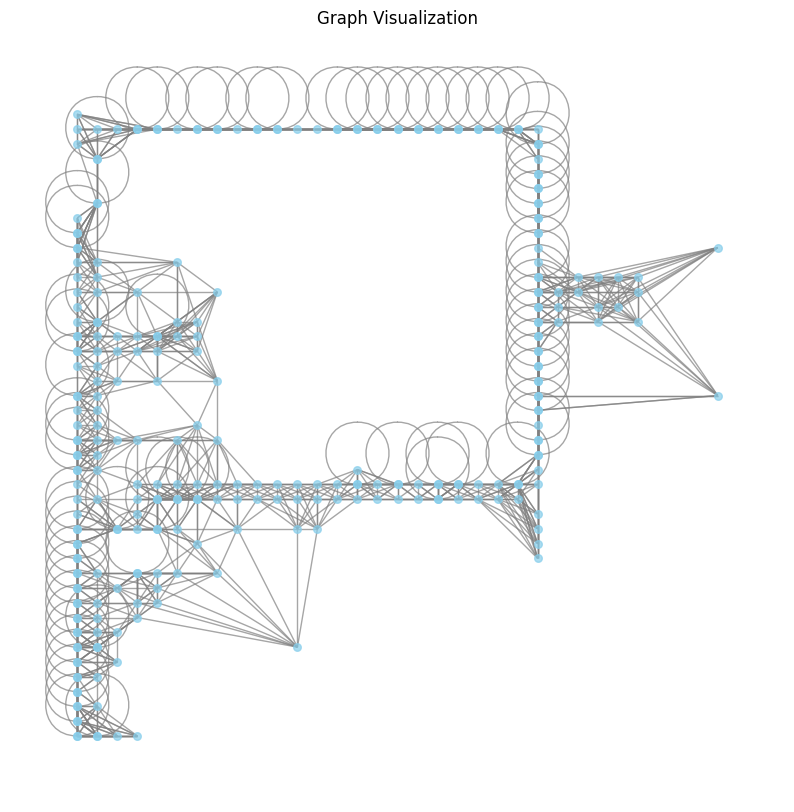

Graph is undirected.


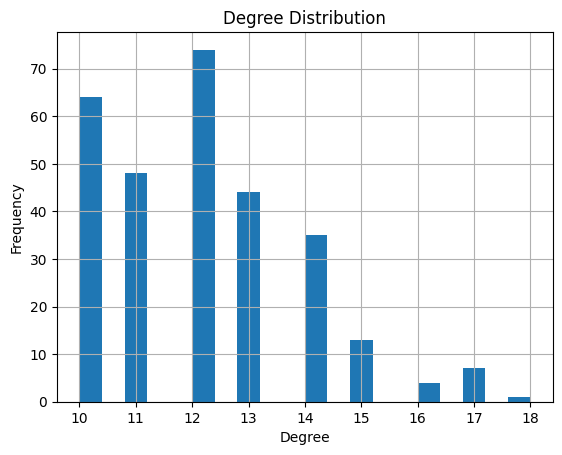

Graph has loops.
Graph has 0 isolated nodes.


In [4]:
#### TODO: Task 2 - Graph Analysis

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def analyze_graph(G):
    # Analyze directionality
    is_directed = nx.is_directed(G)
    print(f"Graph is {'directed' if is_directed else 'undirected'}.")

    # Degree distribution
    degree_distribution = [d for _, d in G.degree()]
    plt.hist(degree_distribution, bins=20)
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Check for loops
    has_loops = nx.number_of_selfloops(G) > 0
    print(f"Graph has {'loops' if has_loops else 'no loops'}.")

    # Identify isolated nodes
    isolated_nodes = list(nx.isolates(G))
    print(f"Graph has {len(isolated_nodes)} isolated nodes.")

def visualize_graph(data):
    G = to_networkx(data, to_undirected=True)

    # x,y projection
    pos = {i: (float(data.pos[i][0]), float(data.pos[i][1])) for i in range(data.num_nodes)}

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_size=30,
        node_color="skyblue",
        edge_color="gray",
        alpha=0.7
    )
    plt.title("Graph Visualization")
    plt.show()

    return G

G = visualize_graph(data)
analyze_graph(G)

## Graph Neural Networks

In [5]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch

class GCN(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.conv1 = GCNConv(in_channels, 64) # First GCN layer: input → 64 hidden features
        self.bn1 = torch.nn.BatchNorm1d(64) # Normalize activations

        self.conv2 = GCNConv(64, 32) # Second GCN layer: 64 → 32 hidden features
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.dropout = torch.nn.Dropout(p=0.3) # Dropout for regularization
        self.out = Linear(32, 2) # Final linear layer for regression to (x, y) position

    def forward(self, x, edge_index):
        h = self.dropout(F.relu(self.bn1(self.conv1(x, edge_index))))
        h = self.dropout(F.relu(self.bn2(self.conv2(h, edge_index))))
        z = self.out(h)
        return h, z

model = GCN(in_channels=data.rssi.shape[1])
print(model)

GCN(
  (conv1): GCNConv(400, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 32)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=32, out_features=2, bias=True)
)


## Task Implementation (Task 3)

In [6]:
#### TODO: Task 3 - Task Definition (Node Regression)

# Loss function for regression
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Tracking
embeddings = []
losses = []
rmses = []
outputs = []

# Diagnostics
print(f"Train nodes: {data.train_mask.sum().item()}, Test nodes: {data.test_mask.sum().item()}")

# Training loop
for epoch in range(501):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.rssi, data.edge_index)

    # Train loss and backward
    train_loss = criterion(z[data.train_mask], data.pos[data.train_mask])
    train_rmse = train_loss.sqrt().item()
    train_loss.backward()
    optimizer.step()

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        h, z = model(data.rssi, data.edge_index)
        test_loss = criterion(z[data.test_mask], data.pos[data.test_mask])
        test_rmse = test_loss.sqrt().item()

    # Save history
    embeddings.append(h.detach())
    outputs.append(z.detach())
    losses.append(train_rmse)
    rmses.append(test_rmse)

    # Print
    if epoch % 10 == 0:
        print(f"Epoch {epoch:>3} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

Train nodes: 232, Test nodes: 58
Epoch   0 | Train RMSE: 20.3807 | Test RMSE: 21.0043
Epoch  10 | Train RMSE: 18.5239 | Test RMSE: 18.4221
Epoch  20 | Train RMSE: 16.3560 | Test RMSE: 15.8246
Epoch  30 | Train RMSE: 13.6412 | Test RMSE: 12.9550
Epoch  40 | Train RMSE: 10.3427 | Test RMSE: 10.0696
Epoch  50 | Train RMSE: 7.6108 | Test RMSE: 7.1023
Epoch  60 | Train RMSE: 5.3685 | Test RMSE: 6.9171
Epoch  70 | Train RMSE: 3.8927 | Test RMSE: 5.2766
Epoch  80 | Train RMSE: 3.3974 | Test RMSE: 2.2144
Epoch  90 | Train RMSE: 3.5491 | Test RMSE: 2.3157
Epoch 100 | Train RMSE: 3.4874 | Test RMSE: 2.0134
Epoch 110 | Train RMSE: 3.4889 | Test RMSE: 1.8178
Epoch 120 | Train RMSE: 3.3791 | Test RMSE: 1.8558
Epoch 130 | Train RMSE: 3.2440 | Test RMSE: 1.7132
Epoch 140 | Train RMSE: 3.2606 | Test RMSE: 1.8814
Epoch 150 | Train RMSE: 3.3912 | Test RMSE: 1.6962
Epoch 160 | Train RMSE: 3.3012 | Test RMSE: 1.7221
Epoch 170 | Train RMSE: 3.2913 | Test RMSE: 1.4242
Epoch 180 | Train RMSE: 3.1446 | Test R

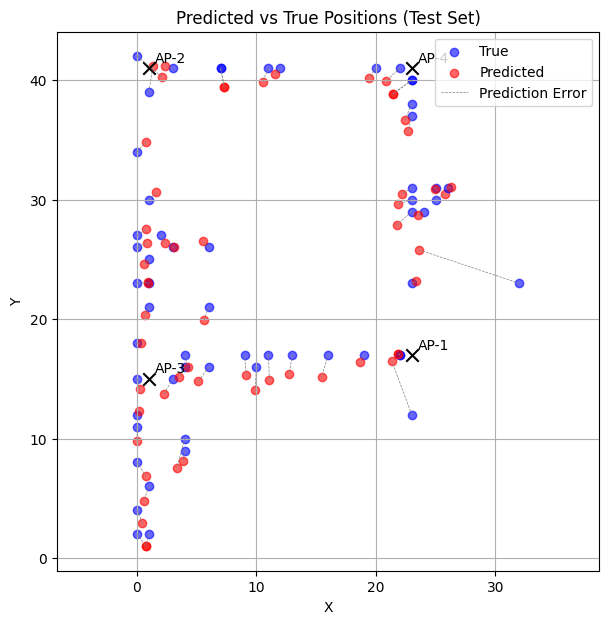

In [7]:
## Visualize predicted vs true positions on the test set
model.eval()
with torch.no_grad():
    _, z = model(data.rssi, data.edge_index)

# Extract indices of test set nodes
test_idx = data.test_mask.nonzero(as_tuple=True)[0]

# Get predicted and true positions for test nodes
pred_pos = z[test_idx].cpu().numpy()
true_pos = data.pos[test_idx].cpu().numpy()

# Access point's positions
access_points = {
    "1": (23, 17),
    "4": (23, 41),
    "3": (1, 15),
    "2": (1, 41)
}

# Plot predicted and true positions
plt.figure(figsize=(7, 7))
for i in range(len(test_idx)):
    x_true, y_true = true_pos[i, :2]
    x_pred, y_pred = pred_pos[i, :2]

    plt.scatter(x_true, y_true, color='blue', alpha=0.6)
    plt.scatter(x_pred, y_pred, color='red', alpha=0.6)

    plt.plot([x_true, x_pred], [y_true, y_pred], 'gray', linestyle='--', linewidth=0.5)

# Plot AP
for label, (x, y) in access_points.items():
    plt.scatter(x, y, color='black', s=80, marker='x')
    plt.text(x + 0.5, y + 0.5, f"AP-{label}", fontsize=10, color='black')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Predicted vs True Positions (Test Set)")
plt.grid(True)
plt.axis("equal")
plt.legend(["True", "Predicted", "Prediction Error"], loc='best')
plt.show()